In [ ]:
import os
!ls
# Change to the cloned repo directory (optional)
!git clone "https://github.com/ezragershman/spotify-listening-data"
%cd '/content/spotify-listening-data'

for dirname, _, filenames in os.walk('/content/spotify-listening-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [2]:
%cd '/content/spotify-listening-data'
from google.colab import userdata
github_token = userdata.get('github_token')

!git config --global user.email "ezragersh@gmail.com"
!git config --global user.name "ezragershman"
# Set up Git to use the token for authentication
if github_token:
    repo_url = f"https://{github_token}@github.com/ezragershman/spotify-listening-data.git"  # Replace 'YourGitHubUsername' and 'YourRepository' with your actual GitHub username and repo
    !git remote set-url origin {repo_url}
    !git add *
    !git commit -m "Created a buynch of graphs;"
    !git push origin main
else:
    print("GitHub token is not available.")

/content/spotify-listening-data
[main 64242cc] Created a buynch of graphs;
Enumerating objects: 23, done.
Counting objects: 100% (23/23), done.
Delta compression using up to 2 threads
Compressing objects: 100% (21/21), done.
Writing objects: 100% (21/21), 750.03 KiB | 2.07 MiB/s, done.
Total 21 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ezragershman/spotify-listening-data.git
   df3570b..64242cc  main -> main


# **MAIN FUNCTION TO UPDATE & SAVE MUSIC LIBRARY DATABASE**


In [ ]:
json_file_path = "/content/spotify-listening-data/data/raw/Streaming_History_Audio_2013-2024.json"
json_to_csv(json_file_path)

Data successfully updated and saved to /content/spotify-listening-data/data/processed/spotify_data.csv


In [ ]:
import pandas as pd
import uuid
import os
import requests

def json_to_csv(json_file_path, csv_output_path='/content/spotify-listening-data/data/processed/spotify_data.csv', geolocation_file='/content/spotify-listening-data/data/processed/ipads processing/geolocated_ips.csv'):
    # Load the new JSON data into a DataFrame
    new_data = pd.read_json(json_file_path)

    # Rename columns for consistency
    new_data.rename(columns={
        'ts': 'end_time_UTC',
        'platform': 'platform',
        'ms_played': 'ms_played',
        'conn_country': 'connection_country',
        'ip_addr_decrypted': 'ip_address',
        'master_metadata_track_name': 'track_name',
        'master_metadata_album_artist_name': 'album_artist_name',
        'master_metadata_album_album_name': 'album_name',
        'spotify_track_uri': 'track_uri',
        'episode_name': 'episode_name',
        'episode_show_name': 'episode_show_name',
        'spotify_episode_uri': 'episode_uri',
        'reason_start': 'start_reason',
        'reason_end': 'end_reason',
        'shuffle': 'shuffle',
        'skipped': 'skipped',
    }, inplace=True)

    # Load the geolocation data into a DataFrame (assuming it contains the relevant information)
    geolocated_ips_df = pd.read_csv(geolocation_file)

    # Merge the new data with the geolocation data based on the 'ip_address'
    # This will add columns like 'city', 'region', 'country', 'latitude', 'longitude', 'local_time_zone', and 'utc_offset'
    new_data = new_data.merge(
       geolocated_ips_df[['unique_ip_address', 'city', 'region', 'country', 'latitude', 'longitude', 'local_time_zone', 'utc_offset']],
       left_on='ip_address',
       right_on='unique_ip_address',
       how='left'
       )

    # Generate a unique ID for each row
    new_data['unique_id'] = new_data['end_time_UTC'].apply(lambda x: f"{x}_{uuid.uuid4().hex[:8]}")

    # Keep only the relevant columns for the CSV
    new_data = new_data[['unique_id', 'end_time_UTC', 'platform', 'ms_played', 'connection_country',
                        'ip_address', 'track_name', 'album_artist_name', 'album_name',
                        'track_uri', 'episode_name', 'episode_show_name', 'episode_uri',
                        'start_reason', 'end_reason', 'shuffle', 'skipped',
                        'city', 'region', 'country', 'latitude', 'longitude',
                        'local_time_zone', 'utc_offset']]  # Include geolocation and timezone columns

    # If the output CSV already exists, read it to check for duplicates
    if os.path.exists(csv_output_path):
        existing_data = pd.read_csv(csv_output_path)

        # Identify and keep only new rows that are not already in the CSV
        merged_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=['unique_id'], keep='first')
    else:
        # If no existing CSV, just use new data
        merged_data = new_data

    # Ensure the 'processed' directory exists (create it if not)
    os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

    # Save updated data to CSV in the specified path
    merged_data.to_csv(csv_output_path, index=False)

    print(f"Data successfully updated and saved to {csv_output_path}")

In [ ]:
# Import required libraries
import requests
import pandas as pd
import time
from google.colab import userdata
from base64 import b64encode

# Step 1: Set up Spotify credentials as environment variables in Google Colab
CLIENT_ID = userdata.get('spotify_client_id')
CLIENT_SECRET = userdata.get('spotify_client_sec')

# Step 1: Get access token from Spotify API
def get_access_token(client_id, client_secret):
    """Fetches an access token from the Spotify API using Client Credentials Flow."""
    print("Requesting access token...")
    auth_header = b64encode(f"{client_id}:{client_secret}".encode('utf-8')).decode('utf-8')
    headers = {
        'Authorization': f'Basic {auth_header}',
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}

    response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data)
    if response.status_code == 200:
        print("Access token obtained successfully.")
        return response.json()['access_token']
    else:
        print("Failed to get access token")
        print(response.json())  # Debugging output for errors
        return None

# Step 2: Fetch song details from Spotify API
def get_song_details(track_uri, access_token):
    """Fetches song details for a given track URI using the Spotify API."""
    print(f"Fetching details for track URI: {track_uri}...")
    headers = {
        'Authorization': f'Bearer {access_token}',
    }
    track_id = track_uri.split(':')[-1]  # Extract track ID from URI
    url = f'https://api.spotify.com/v1/tracks/{track_id}'

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        track_info = response.json()
        print(f"Details for {track_uri} fetched successfully.")
        return {
            'song_duration_ms': track_info['duration_ms'],
            'album_type': track_info['album']['album_type'],
            'explicit': track_info['explicit'],
            'available_markets': track_info['available_markets']
        }
    elif response.status_code == 429:
        # Handle rate limits
        retry_after = int(response.headers.get('Retry-After', 1))
        print(f"Rate limited. Waiting for {retry_after} seconds...")
        time.sleep(retry_after)
        return None
    else:
        print(f"Error fetching data for {track_uri}: {response.status_code}")
        print(response.text)  # Detailed error logging
        return None

# Step 3: Load or create a lookup table
def load_lookup_table(file_path):
    """Loads an existing lookup table or creates a new one if not found."""
    try:
        print(f"Loading lookup table from {file_path}...")
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print("Lookup table not found, creating a new one.")
        return pd.DataFrame(columns=['track_uri', 'song_duration_ms', 'album_type', 'explicit', 'available_markets'])

# Step 4: Update the lookup table
def update_lookup_table(lookup_table, track_uri, access_token):
    """Fetches and updates song details if not already present in the lookup table."""
    if track_uri in lookup_table['track_uri'].values:
        print(f"Track {track_uri} found in lookup table.")
        song_details = lookup_table[lookup_table['track_uri'] == track_uri].iloc[0].to_dict()
    else:
        print(f"Track {track_uri} not found in lookup table, fetching details...")
        song_details = get_song_details(track_uri, access_token)
        if song_details:
            song_details['track_uri'] = track_uri
            lookup_table = pd.concat([lookup_table, pd.DataFrame([song_details])], ignore_index=True)
        else:
            song_details = None
    return song_details, lookup_table

# Step 5: Fetch song details for only missing URIs
def fetch_song_details(data, lookup_table, save_interval=10):
    """Fetches song details for all URIs in the provided data."""
    print("Fetching song details for all URIs in the data...")
    access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
    if not access_token:
        print("No access token obtained, returning original data.")
        return data, lookup_table

    song_details = []
    total_rows = len(data['track_uri'].dropna())

    # Get track URIs that are in data but not in the lookup table
    existing_uris = lookup_table['track_uri'].dropna().unique()  # Track URIs already in lookup table
    missing_uris = data['track_uri'].dropna().unique()  # All track URIs in the data
    missing_uris = [uri for uri in missing_uris if uri not in existing_uris]  # Find missing ones

    print(f"Found {len(missing_uris)} missing tracks to fetch details for.")

    for idx, track_uri in enumerate(missing_uris):  # Only iterate over missing URIs
        print(f"Processing track {idx+1}/{len(missing_uris)} with URI: {track_uri}")
        details, lookup_table = update_lookup_table(lookup_table, track_uri, access_token)
        song_details.append(details)

        if (idx + 1) % save_interval == 0:
            print(f"Saving progress after processing {idx+1} tracks...")
            valid_song_details = [details for details in song_details if details is not None]  # Filter out None values

            if valid_song_details:
                details_df = pd.DataFrame(valid_song_details).drop_duplicates(subset='track_uri')  # Remove any duplicates
                details_df = details_df.set_index('track_uri')  # Set index for merging

                # Update the main DataFrame, dropping duplicates before setting index
                data = data.drop_duplicates(subset=['track_uri']).set_index('track_uri')
                data.update(details_df)
                data = data.reset_index()  # Restore the index

            # Save intermediate results to CSV
            data.to_csv(file_path, index=False)
            lookup_table.to_csv(lookup_file_path, index=False)
            print(f"Progress saved after {idx+1} tracks.")

            song_details = []  # Clear list after saving
            time.sleep(1)  # Slow down to prevent rate limiting

    print("All song details added successfully.")
    return data, lookup_table



# Step 6: Load existing data and lookup table
file_path = '/content/spotify-listening-data/data/processed/spotify_data.csv'
lookup_file_path = '/content/spotify-listening-data/data/processed/song_lookup_table.csv'

print(f"Loading data from {file_path}...")
spotify_data = pd.read_csv(file_path)
print(f"Loaded {len(spotify_data)} rows of data.")

lookup_table = load_lookup_table(lookup_file_path)

# Step 7: Fetch and update song details
spotify_data, lookup_table = fetch_song_details(spotify_data, lookup_table, save_interval=10)

# Step 8: Save final results
spotify_data.to_csv(file_path, index=False)
lookup_table.to_csv(lookup_file_path, index=False)
print(f"Updated data saved to {file_path}.")
print(f"Updated lookup table saved to {lookup_file_path}.")
print("Process completed successfully!")



In [ ]:
import pandas as pd

# Step 1: Load the CSV files and inspect their columns
lookup_file_path = '/content/spotify-listening-data/data/processed/song_lookup_table.csv'
lookup_table = pd.read_csv(lookup_file_path)

spotify_data_file_path = '/content/spotify-listening-data/data/processed/spotify_data.csv'
spotify_data = pd.read_csv(spotify_data_file_path)

# Step 2: Check columns before merging (for verification)
print("Columns in spotify_data:")
print(spotify_data.columns)
print("\nColumns in lookup_table:")
print(lookup_table.columns)

# Step 3: Perform the merge on 'track_uri' without dropping the key column
merged_data = pd.merge(spotify_data, lookup_table, on='track_uri', how='left')

# Step 4: Print a preview of the merged data
print("\nPreview of merged data (after merging):")
print(merged_data.head())

# Step 5: Save the merged data back to the original CSV file
merged_data.to_csv(spotify_data_file_path, index=False)
print(f"Merged data has been saved to {spotify_data_file_path}.")

In [22]:
spotify_data_path = '/content/spotify-listening-data/data/processed/spotify_data.csv'
spotify_df = pd.read_csv(spotify_data_path)

spotify_df.columns

Index(['track_uri', 'unique_id', 'end_time_UTC', 'platform', 'ms_played',
       'connection_country', 'ip_address', 'track_name', 'album_artist_name',
       'album_name', 'episode_name', 'episode_show_name', 'episode_uri',
       'start_reason', 'end_reason', 'shuffle', 'skipped', 'city', 'region',
       'country', 'latitude', 'longitude', 'local_time_zone', 'utc_offset',
       'song_duration_ms_x', 'album_type_x', 'explicit_x',
       'available_markets_x', 'song_duration_ms_y', 'album_type_y',
       'explicit_y', 'available_markets_y'],
      dtype='object')

# **IP Address Information Scraper**

In [ ]:
import pandas as pd
# Create table for unique ID information.

def extract_unique_ips(json_file_path, output_csv_path='/content/spotify-listening-data/data/processed/ipads processing/unique_ips.csv'):
    # Load the JSON data into a DataFrame
    data = pd.read_json(json_file_path)

    # Extract the IP address column (adjust column name based on your data)
    ip_addresses = data['ip_addr_decrypted']  # Ensure 'ip_addr_decrypted' is the correct column name

    # Get the unique IP addresses
    unique_ips = ip_addresses.dropna().unique()

    # Create a DataFrame from the unique IP addresses
    unique_ips_df = pd.DataFrame(unique_ips, columns=['unique_ip_address'])

    # Save the unique IPs to a CSV file
    unique_ips_df.to_csv(output_csv_path, index=False)

    print(f"Unique IP addresses extracted and saved to {output_csv_path}")

# Example usage
json_file_path = '/content/spotify-listening-data/data/raw/Streaming_History_Audio_2013-2024.json'
extract_unique_ips(json_file_path)


Unique IP addresses extracted and saved to /content/spotify-listening-data/data/processed/unique_ips.csv


In [ ]:
import pandas as pd
from ipaddress import ip_network, ip_address

# Load IP data into DataFrame (assuming your list is saved as 'unique_ips.csv')
df = pd.read_csv('/content/spotify-listening-data/data/processed/ipads processing/unique_ips.csv')

def group_by_subnet(ip):
    try:
        # If it's an IPv4 address
        ip_obj = ip_address(ip)
        if ip_obj.version == 4:
            return f"{ip_obj.exploded.split('.')[0]}.{ip_obj.exploded.split('.')[1]}.{ip_obj.exploded.split('.')[2]}.0/24"
        else:
            # For IPv6, return the first few blocks (customizable)
            return ':'.join(ip.split(':')[:4]) + '::/64'
    except ValueError:
        return 'Invalid IP'

# Apply subnet grouping
df['subnet'] = df['unique_ip_address'].apply(group_by_subnet)

# Drop duplicates based on subnets, keeping one representative IP
deduplicated_ip = df.drop_duplicates(subset='subnet')

# Save the deduplicated DataFrame as a CSV file
deduplicated_ip.to_csv('/content/spotify-listening-data/data/processed/ipads processing/deduplicated_unique_ips.csv', index=False)

In [ ]:
import time
import pandas as pd
from ip2geotools.databases.noncommercial import DbIpCity

# Load previously processed IPs from CSV if it exists
def load_processed_ips(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} previously processed IPs from {file_path}.")
        return set(df['unique_ip_address'].tolist())  # Assuming the CSV has a column named 'unique_ip_address'
    except FileNotFoundError:
        print(f"No previous geolocated IPs found. Starting fresh.")
        return set()

# Save new processed IPs to the CSV
def save_processed_ips(file_path, processed_ips):
    df = pd.DataFrame(list(processed_ips), columns=['unique_ip_address'])
    df.to_csv(file_path, index=False)
    print(f"Saved {len(processed_ips)} processed IPs to {file_path}.")

# Path to the CSV files
deduplicated_ips_file = '/content/spotify-listening-data/data/processed/ipads processing/deduplicated_unique_ips.csv'
geolocated_ips_file = '/content/spotify-listening-data/data/processed/ipads processing/geolocated_ips.csv'

# Load the IPs
print("Loading deduplicated IPs...")
deduplicated_df = pd.read_csv(deduplicated_ips_file)
print(f"Loaded {len(deduplicated_df)} deduplicated IPs from {deduplicated_ips_file}.")

processed_ips = load_processed_ips(geolocated_ips_file)

# Function to get location details from IP address
def get_location_from_ip(ip_address):
    try:
        # Query the ip2geotools database with the given IP address
        res = DbIpCity.get(ip_address, api_key="free")

        # Structure the location data
        location = {
            "city": res.city,
            "region": res.region,
            "country": res.country,
            "latitude": res.latitude,
            "longitude": res.longitude
        }
        return location
    except Exception as e:
        # Handle any potential errors
        return {
            "city": None,
            "region": None,
            "country": None,
            "latitude": None,
            "longitude": None,
            "error": f"Error: {str(e)}"
        }

# Add columns to store location data if not already present
if 'city' not in deduplicated_df.columns:
    print("Adding location columns to deduplicated IP data...")
    deduplicated_df['city'] = None
    deduplicated_df['region'] = None
    deduplicated_df['country'] = None
    deduplicated_df['latitude'] = None
    deduplicated_df['longitude'] = None

# Start processing IPs
print("Starting IP geolocation processing...")

new_geolocated_data = []  # To store new geolocated IP data

for idx, ip in enumerate(deduplicated_df['unique_ip_address']):
    print(ip)
    # Check if this IP has already been processed
    if ip not in processed_ips:
        # Get location data for unprocessed IPs
        print(f"Processing IP {idx + 1}/{len(deduplicated_df)}: {ip}")
        location_data = get_location_from_ip(ip)
        deduplicated_df.at[idx, 'city'] = location_data['city']
        deduplicated_df.at[idx, 'region'] = location_data['region']
        deduplicated_df.at[idx, 'country'] = location_data['country']
        deduplicated_df.at[idx, 'latitude'] = location_data['latitude']
        deduplicated_df.at[idx, 'longitude'] = location_data['longitude']

        # Add the IP to the processed list
        processed_ips.add(ip)

        # Store new geolocated data
        new_geolocated_data.append({
            "unique_ip_address": ip,
            "city": location_data['city'],
            "region": location_data['region'],
            "country": location_data['country'],
            "latitude": location_data['latitude'],
            "longitude": location_data['longitude']
        })

        # Log the geolocation
        print(f"Processed {ip}: {location_data['city']}, {location_data['region']}, {location_data['country']}")

    # Wait 10 seconds to avoid hitting rate limits
    time.sleep(10)

# Save the updated deduplicated DataFrame back to the original CSV
print("Saving updated deduplicated IPs to CSV...")
deduplicated_df.to_csv(deduplicated_ips_file, index=False)

# Save the processed IPs to the geolocated file
if new_geolocated_data:
    new_geolocated_df = pd.DataFrame(new_geolocated_data)
    new_geolocated_df.to_csv(geolocated_ips_file, index=False)

# Save the processed IPs to the geolocated file
save_processed_ips(geolocated_ips_file, processed_ips)

print("Geolocation data added and saved successfully.")


In [ ]:
# To remove the time zone and UTC offset columns, if needed
geolocated_ips.drop(columns=['local_time_zone', 'utc_offset'], inplace=True)

In [ ]:
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from pytz import timezone
from datetime import datetime

# Function to get timezone and UTC offset for a given city and country
def get_timezone_and_offset(city, country, region=None):
    geolocator = Nominatim(user_agent="timezone_lookup")

    # First attempt: geocode using city and country
    location = geolocator.geocode(f"{city}, {country}", timeout=10)

    if location:
        latitude = location.latitude
        longitude = location.longitude
        tz_finder = TimezoneFinder()
        tz_name = tz_finder.timezone_at(lng=longitude, lat=latitude)

        if tz_name:
            tz = timezone(tz_name)
            utc_offset = tz.utcoffset(datetime.now()).total_seconds() / 3600  # in hours
            return tz_name, utc_offset
        else:
            return 'Unknown', None

    else:
        # Second attempt: geocode using region if city-based lookup fails
        if region:
            location = geolocator.geocode(f"{region}, {country}", timeout=10)

            if location:
                latitude = location.latitude
                longitude = location.longitude
                tz_finder = TimezoneFinder()
                tz_name = tz_finder.timezone_at(lng=longitude, lat=latitude)

                if tz_name:
                    tz = timezone(tz_name)
                    utc_offset = tz.utcoffset(datetime.now()).total_seconds() / 3600  # in hours
                    return tz_name, utc_offset
                else:
                    return 'Unknown', None
        return 'Unknown', None  # Return 'Unknown' if both lookups fail

# Apply the function to your DataFrame
def add_time_zone_info(df):
    df[['local_time_zone', 'utc_offset']] = df.apply(
        lambda row: pd.Series(get_timezone_and_offset(row['city'], row['country'], row['region'])),
        axis=1
    )
    return df

# Load the data
geolocated_ips = pd.read_csv('/content/spotify-listening-data/data/processed/ipads processing/geolocated_ips.csv')

# Apply the function to add time zone information
geolocated_ips = add_time_zone_info(geolocated_ips)

# Export the updated file
geolocated_ips.to_csv('/content/spotify-listening-data/data/processed/ipads processing/geolocated_ips.csv', index=False)



# **DATA ANALYSIS AND MANIPULATION**:

In [10]:
import pandas as pd

# Load the Spotify listening data
spotify_data_path = '/content/spotify-listening-data/data/processed/spotify_data.csv'
spotify_df = pd.read_csv(spotify_data_path)

# Display the first few rows and summary of the data
print("First few rows of the data:")
print(spotify_df.head())

print("\nData structure (columns and data types):")
print(spotify_df.info())

print("\nSummary statistics:")
print(spotify_df.describe(include='all'))

First few rows of the data:
                              track_uri                      unique_id  \
0                                   NaN  2013-10-13T15:15:10Z_6cdee161   
1  spotify:track:7p7chfq7OqmGmpwWWnPz0p  2013-10-13T15:15:26Z_082a86db   
2  spotify:track:5cwAwML79FCaUyPEpEmrIh  2013-10-13T15:15:28Z_b922befa   
3  spotify:track:2XjZtWBjcvYtVxcXPVoEHi  2013-10-13T15:15:29Z_955600b9   
4  spotify:track:4AJY2aMfSaJip3o1JJCRCs  2013-10-13T15:15:35Z_88ef0788   

           end_time_UTC             platform  ms_played connection_country  \
0  2013-10-13T15:15:10Z  OS X 10.8.4 [x86 4]      39381                 US   
1  2013-10-13T15:15:26Z  OS X 10.8.4 [x86 4]      16427                 US   
2  2013-10-13T15:15:28Z  OS X 10.8.4 [x86 4]       3204                 US   
3  2013-10-13T15:15:29Z  OS X 10.8.4 [x86 4]       2136                 US   
4  2013-10-13T15:15:35Z  OS X 10.8.4 [x86 4]       5313                 US   

     ip_address      track_name         album_artist_name 

# **Listening Trends Over Time:**
Analyze Spotify listening trends over different time periods (monthly, daily, and weekly).

## Data Preparation:



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from datetime import timedelta

# Step 1: Load the data (replace with actual data loading process)
# Assuming the data is loaded from a CSV or another source
new_data = pd.read_csv('/content/spotify-listening-data/data/processed/spotify_data.csv')

# Step 2: Convert 'end_time_UTC' to datetime
new_data['end_time_UTC'] = pd.to_datetime(new_data['end_time_UTC'])

# Step 3: Convert UTC to Local Time
# We'll adjust the 'end_time_UTC' column to local time using the 'utc_offset' column.

# Function to convert from UTC to local time
def convert_to_local_time(row):
    # If 'utc_offset' is NaN, return the original UTC time (or handle as appropriate)
    if pd.isna(row['utc_offset']):
        return row['end_time_UTC']

    utc_time = row['end_time_UTC']
    utc_offset = row['utc_offset']

    # Apply UTC offset to convert to local time
    local_time = utc_time + timedelta(hours=utc_offset)
    return local_time

# Apply the function to create a new 'end_time_local' column
new_data['end_time_local'] = new_data.apply(convert_to_local_time, axis=1)

# Step 4: Apply the function to create a new 'end_time_local' column
new_data['end_time_local'] = new_data.apply(convert_to_local_time, axis=1)

# Step 5: Extract Time Features from 'end_time_local' (if not NaN)
# Now that we have 'end_time_local', we'll extract day of the week, hour, and month.

# Make sure to handle cases where 'end_time_local' might be NaN (if there were missing UTC offsets)
# We can use `.dt` accessor to extract day of the week, hour, and month

# First, we need to check for non-NaT values in 'end_time_local'
new_data = new_data[new_data['end_time_local'].notna()]

# Extract 'day_of_week', 'hour', and 'month' from 'end_time_local'
new_data['day_of_week'] = new_data['end_time_local'].dt.weekday  # 0=Monday, 6=Sunday
new_data['hour'] = new_data['end_time_local'].dt.hour  # Extract the hour
new_data['month'] = new_data['end_time_local'].dt.month  # Extract the month
new_data['year'] = new_data['end_time_local'].dt.year  # Extract the year

# Select desired columns for analysis
relevant_columns = ['unique_id', 'platform', 'ms_played', 'track_name',
                    'album_artist_name', 'album_name', 'episode_name',
                    'episode_show_name', 'episode_uri', 'start_reason',
                    'end_reason', 'shuffle', 'skipped', 'city', 'region',
                    'country', 'song_duration_ms', 'album_type', 'explicit',
                    'available_markets', 'end_time_local', 'day_of_week',
                    'hour', 'month', 'year']

# Filter the DataFrame to only keep these columns
filtered_data = new_data[relevant_columns]

# Preview the filtered data
print(filtered_data.head())

## **DATA MANIPULATION**

### *Listening Patterns by Hour of Day*

<ipython-input-17-ca016a3ec7bd>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=listening_by_hour, x='hour', y='ms_played_minutes', palette='viridis')


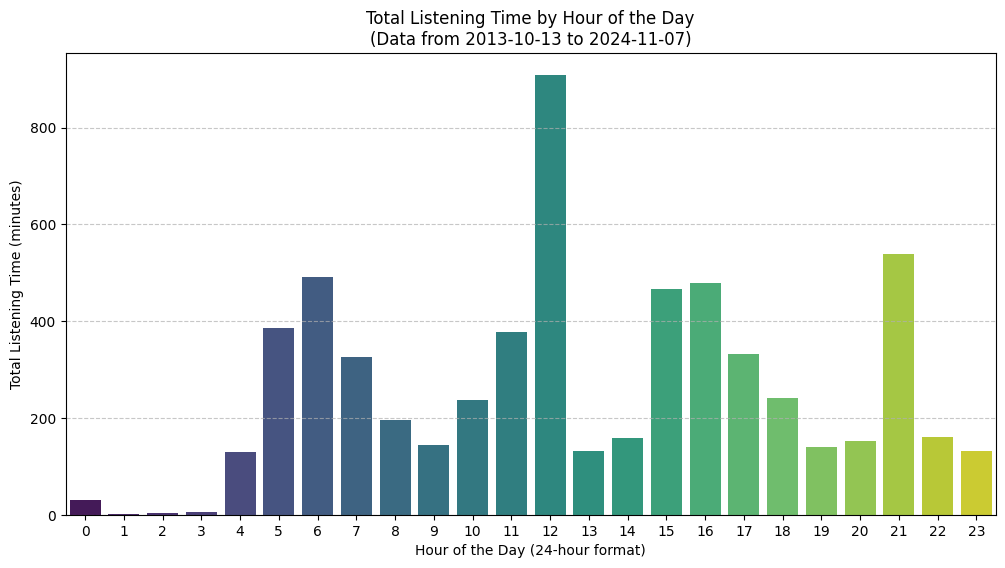

Chart saved to /content/spotify-listening-data/output/charts/listening_by_hour.png


In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create output directory for charts if it doesn't exist
output_dir = '/content/spotify-listening-data/output/charts'
os.makedirs(output_dir, exist_ok=True)

# Convert end_time_local to datetime if not already
new_data['end_time_local'] = pd.to_datetime(new_data['end_time_local'])

# Convert ms_played to minutes
new_data['ms_played_minutes'] = new_data['ms_played'] / 60000  # Convert milliseconds to minutes

# Determine the date range for the title
start_date = new_data['end_time_local'].min().strftime('%Y-%m-%d')
end_date = new_data['end_time_local'].max().strftime('%Y-%m-%d')

# Group data by the hour
listening_by_hour = new_data.groupby('hour')['ms_played_minutes'].sum().reset_index()

# Create a barplot to visualize listening trends by hour
plt.figure(figsize=(12, 6))
sns.barplot(data=listening_by_hour, x='hour', y='ms_played_minutes', palette='viridis')
plt.title(f'Total Listening Time by Hour of the Day\n(Data from {start_date} to {end_date})')
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Total Listening Time (minutes)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to the output folder
output_path = os.path.join(output_dir, 'listening_by_hour.png')
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print(f'Chart saved to {output_path}')



### *Monthly Listening Trends*

<ipython-input-19-e8183aa93474>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=listening_by_month, x='month', y='ms_played_minutes', palette='viridis')


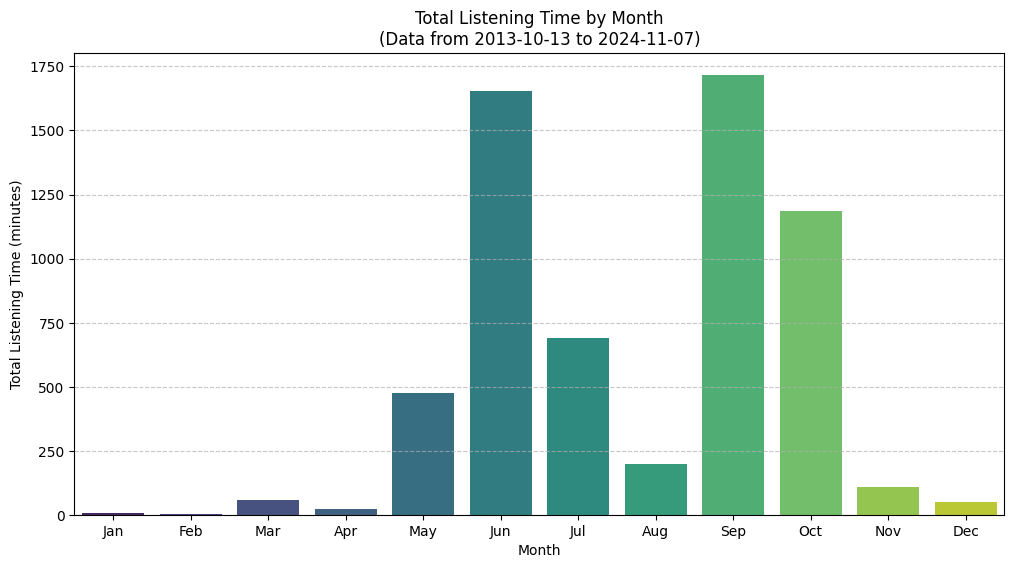

Chart saved to /content/spotify-listening-data/output/charts/listening_by_month.png


In [19]:
# Group data by month and calculate total listening time in minutes
listening_by_month = new_data.groupby('month')['ms_played_minutes'].sum().reset_index()

# Create a barplot to visualize listening trends by month
plt.figure(figsize=(12, 6))
sns.barplot(data=listening_by_month, x='month', y='ms_played_minutes', palette='viridis')
plt.title(f'Total Listening Time by Month\n(Data from {start_date} to {end_date})')
plt.xlabel('Month')
plt.ylabel('Total Listening Time (minutes)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot to the output folder
output_path_month = os.path.join(output_dir, 'listening_by_month.png')
plt.savefig(output_path_month, bbox_inches='tight')
plt.show()

print(f'Chart saved to {output_path_month}')


### Listening Duration and Frequency

<ipython-input-20-c28363c86c9c>:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly_unique_tracks = new_data.groupby(new_data['end_time_local'].dt.to_period('W'))['track_uri'].nunique().reset_index()


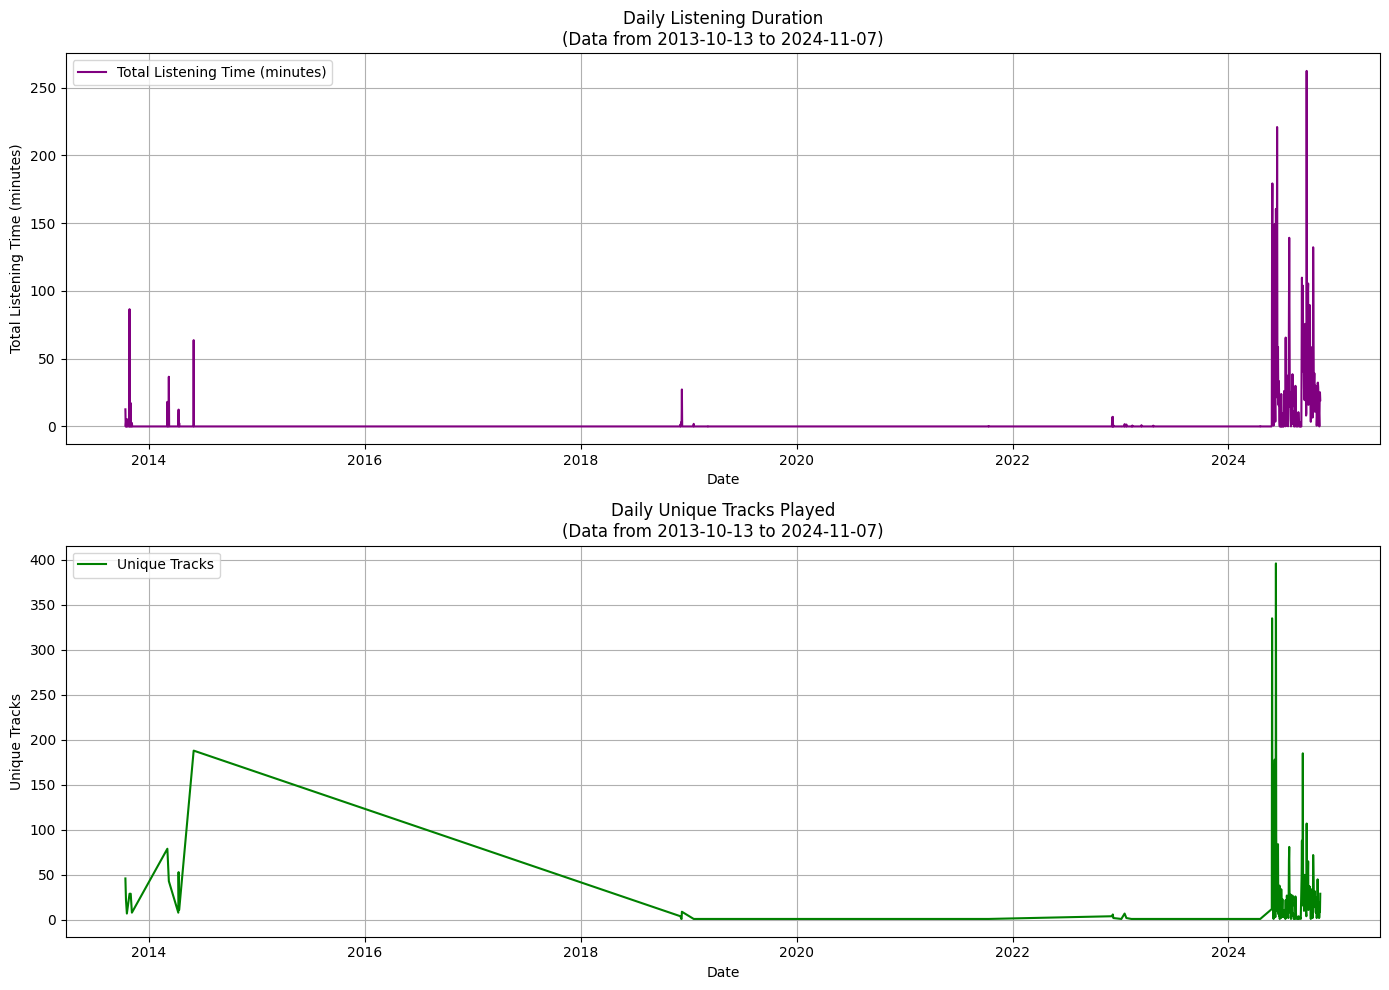

Chart saved to /content/spotify-listening-data/output/charts/listening_duration_frequency.png


In [20]:
# Convert 'end_time_local' to datetime for easier resampling
new_data['end_time_local'] = pd.to_datetime(new_data['end_time_local'])

# Calculate total listening time per day (in minutes)
daily_listening = new_data.resample('D', on='end_time_local')['ms_played_minutes'].sum().reset_index()

# Calculate total listening time per week (in minutes)
weekly_listening = new_data.resample('W', on='end_time_local')['ms_played_minutes'].sum().reset_index()

# Track the number of unique tracks listened to per day
daily_unique_tracks = new_data.groupby(new_data['end_time_local'].dt.date)['track_uri'].nunique().reset_index()

# Track the number of unique tracks listened to per week
weekly_unique_tracks = new_data.groupby(new_data['end_time_local'].dt.to_period('W'))['track_uri'].nunique().reset_index()

# Plot daily listening duration and unique tracks
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot daily listening time
sns.lineplot(data=daily_listening, x='end_time_local', y='ms_played_minutes', ax=ax[0], label='Total Listening Time (minutes)', color='purple')
ax[0].set_title(f'Daily Listening Duration\n(Data from {start_date} to {end_date})')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Listening Time (minutes)')
ax[0].grid(True)

# Plot daily unique tracks listened to
sns.lineplot(data=daily_unique_tracks, x='end_time_local', y='track_uri', ax=ax[1], label='Unique Tracks', color='green')
ax[1].set_title(f'Daily Unique Tracks Played\n(Data from {start_date} to {end_date})')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Unique Tracks')
ax[1].grid(True)

# Save the plot to output folder
output_path_duration_frequency = os.path.join(output_dir, 'listening_duration_frequency.png')
plt.tight_layout()
plt.savefig(output_path_duration_frequency, bbox_inches='tight')
plt.show()

print(f'Chart saved to {output_path_duration_frequency}')

Data from 2024+

<ipython-input-21-22804f38c438>:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly_unique_tracks = new_data_2024_onwards.groupby(new_data_2024_onwards['end_time_local'].dt.to_period('W'))['track_uri'].nunique().reset_index()


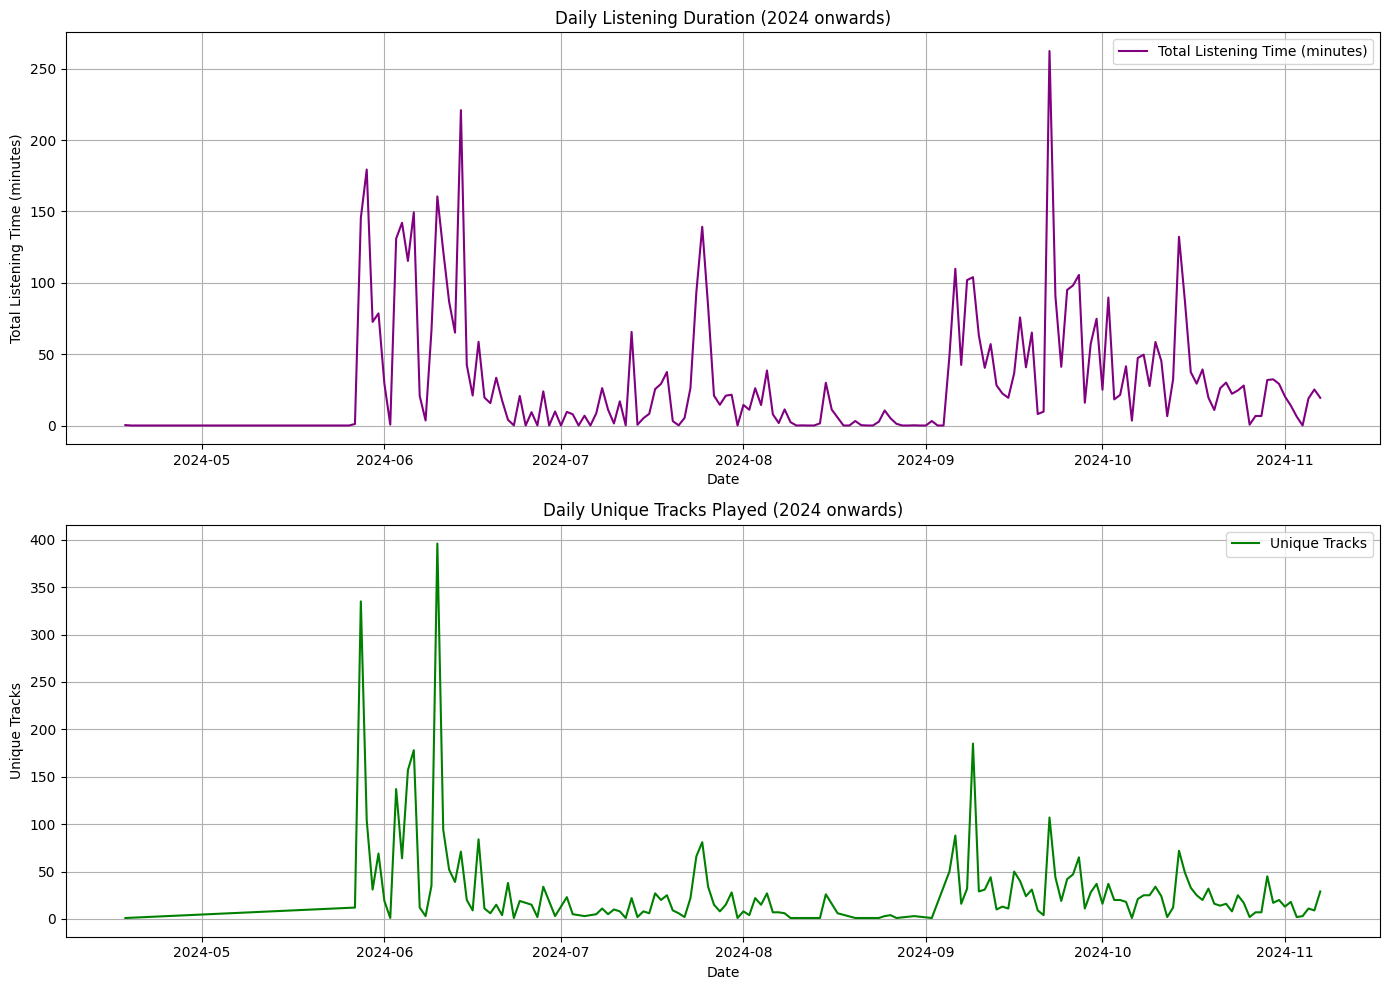

Chart saved to /content/spotify-listening-data/output/charts/listening_duration_frequency_2024.png


In [21]:
# Convert 'end_time_local' to datetime for easier filtering and resampling
new_data['end_time_local'] = pd.to_datetime(new_data['end_time_local'])

# Filter the data for 2024 onwards
new_data_2024_onwards = new_data[new_data['end_time_local'].dt.year >= 2024]

# Calculate total listening time per day (in minutes) for 2024 onwards
daily_listening = new_data_2024_onwards.resample('D', on='end_time_local')['ms_played_minutes'].sum().reset_index()

# Calculate total listening time per week (in minutes) for 2024 onwards
weekly_listening = new_data_2024_onwards.resample('W', on='end_time_local')['ms_played_minutes'].sum().reset_index()

# Track the number of unique tracks listened to per day for 2024 onwards
daily_unique_tracks = new_data_2024_onwards.groupby(new_data_2024_onwards['end_time_local'].dt.date)['track_uri'].nunique().reset_index()

# Track the number of unique tracks listened to per week for 2024 onwards
weekly_unique_tracks = new_data_2024_onwards.groupby(new_data_2024_onwards['end_time_local'].dt.to_period('W'))['track_uri'].nunique().reset_index()

# Plot daily listening duration and unique tracks for 2024 onwards
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot daily listening time
sns.lineplot(data=daily_listening, x='end_time_local', y='ms_played_minutes', ax=ax[0], label='Total Listening Time (minutes)', color='purple')
ax[0].set_title(f'Daily Listening Duration (2024 onwards)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Listening Time (minutes)')
ax[0].grid(True)

# Plot daily unique tracks listened to
sns.lineplot(data=daily_unique_tracks, x='end_time_local', y='track_uri', ax=ax[1], label='Unique Tracks', color='green')
ax[1].set_title(f'Daily Unique Tracks Played (2024 onwards)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Unique Tracks')
ax[1].grid(True)

# Save the plot to output folder
output_path_duration_frequency_2024 = os.path.join(output_dir, 'listening_duration_frequency_2024.png')
plt.tight_layout()
plt.savefig(output_path_duration_frequency_2024, bbox_inches='tight')
plt.show()

print(f'Chart saved to {output_path_duration_frequency_2024}')


### **Top Songs, Artists, or Albums Over Time **

In [24]:
import pandas as pd
import os

# Ensure output folder exists
output_dir = '/content/spotify-listening-data/output'
os.makedirs(output_dir, exist_ok=True)

# Aggregating the data by month and sorting by listening time
# Top Songs by playtime (monthly)
top_songs_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'track_name'])['ms_played_minutes'].sum().reset_index()
top_songs_monthly = top_songs_monthly.sort_values(['end_time_local', 'ms_played_minutes'], ascending=[True, False])

# Save the top songs data to CSV
output_path_top_songs = os.path.join(output_dir, 'top_songs_over_time.csv')
top_songs_monthly.to_csv(output_path_top_songs, index=False)
print(f"Top Songs data saved to {output_path_top_songs}")

# Top Artists by playtime (monthly)
top_artists_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'album_artist_name'])['ms_played_minutes'].sum().reset_index()
top_artists_monthly = top_artists_monthly.sort_values(['end_time_local', 'ms_played_minutes'], ascending=[True, False])

# Save the top artists data to CSV
output_path_top_artists = os.path.join(output_dir, 'top_artists_over_time.csv')
top_artists_monthly.to_csv(output_path_top_artists, index=False)
print(f"Top Artists data saved to {output_path_top_artists}")

# Top Albums by playtime (monthly)
top_albums_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'album_name'])['ms_played_minutes'].sum().reset_index()
top_albums_monthly = top_albums_monthly.sort_values(['end_time_local', 'ms_played_minutes'], ascending=[True, False])

# Save the top albums data to CSV
output_path_top_albums = os.path.join(output_dir, 'top_albums_over_time.csv')
top_albums_monthly.to_csv(output_path_top_albums, index=False)
print(f"Top Albums data saved to {output_path_top_albums}")



Top Songs data saved to /content/spotify-listening-data/output/top_songs_over_time.csv
Top Artists data saved to /content/spotify-listening-data/output/top_artists_over_time.csv
Top Albums data saved to /content/spotify-listening-data/output/top_albums_over_time.csv


<ipython-input-24-490ca53c8fe2>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  top_songs_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'track_name'])['ms_played_minutes'].sum().reset_index()
<ipython-input-24-490ca53c8fe2>:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  top_artists_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'album_artist_name'])['ms_played_minutes'].sum().reset_index()
<ipython-input-24-490ca53c8fe2>:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  top_albums_monthly = new_data.groupby([new_data['end_time_local'].dt.to_period('M'), 'album_name'])['ms_played_minutes'].sum().reset_index()


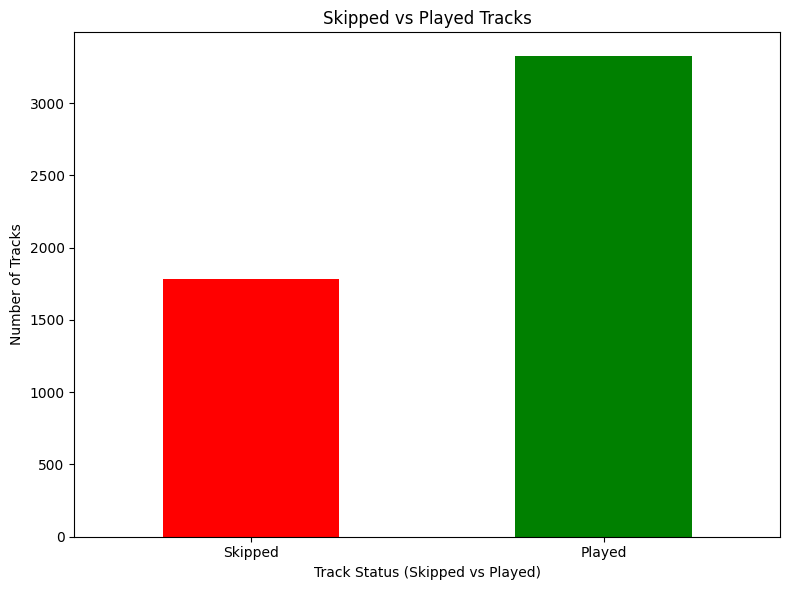

Chart saved to /content/spotify-listening-data/output/skipped_vs_played.png


In [29]:
import matplotlib.pyplot as plt

# Load the data
spotify_data_file_path = '/content/spotify-listening-data/data/processed/spotify_data.csv'
spotify_data = pd.read_csv(spotify_data_file_path)

# Filter out the rows where 'skipped' is NaN (or if 'skipped' is an integer, ensure it is 0 or 1)
spotify_data['skipped'] = spotify_data['skipped'].fillna(0).astype(int)

# Group by skipped vs played
skipped_data = spotify_data.groupby('skipped')['unique_id'].count()

# Plot the number of skipped vs played tracks
plt.figure(figsize=(8, 6))
skipped_data.plot(kind='bar', color=['red', 'green'])
plt.title('Skipped vs Played Tracks')
plt.xlabel('Track Status (Skipped vs Played)')
plt.ylabel('Number of Tracks')
plt.xticks([0, 1], ['Skipped', 'Played'], rotation=0)
plt.tight_layout()

# Save the plot
output_path = '/content/spotify-listening-data/output/skipped_vs_played.png'
plt.savefig(output_path)
plt.show()

print(f"Chart saved to {output_path}")


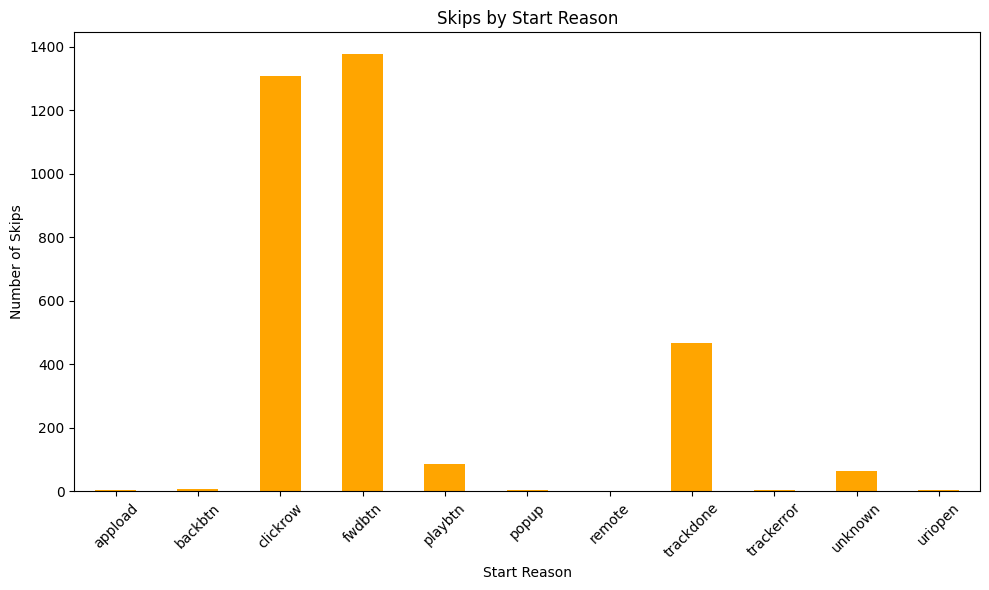

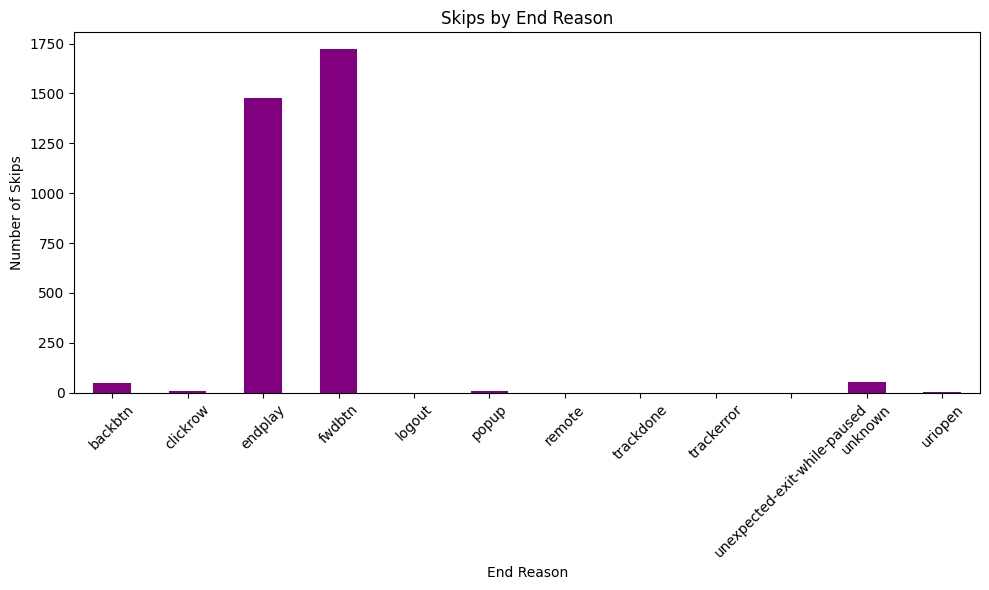

Charts saved to /content/spotify-listening-data/output/skips_by_start_reason.png and /content/spotify-listening-data/output/skips_by_end_reason.png


In [30]:
# Count skips by 'start_reason' and 'end_reason'
skip_by_start_reason = spotify_data.groupby('start_reason')['skipped'].sum()
skip_by_end_reason = spotify_data.groupby('end_reason')['skipped'].sum()

# Plot the skipped data by 'start_reason'
plt.figure(figsize=(10, 6))
skip_by_start_reason.plot(kind='bar', color='orange')
plt.title('Skips by Start Reason')
plt.xlabel('Start Reason')
plt.ylabel('Number of Skips')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_path_start = '/content/spotify-listening-data/output/skips_by_start_reason.png'
plt.savefig(output_path_start)
plt.show()

# Plot the skipped data by 'end_reason'
plt.figure(figsize=(10, 6))
skip_by_end_reason.plot(kind='bar', color='purple')
plt.title('Skips by End Reason')
plt.xlabel('End Reason')
plt.ylabel('Number of Skips')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_path_end = '/content/spotify-listening-data/output/skips_by_end_reason.png'
plt.savefig(output_path_end)
plt.show()

print(f"Charts saved to {output_path_start} and {output_path_end}")


<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 26241 (\N{CJK UNIFIED IDEOGRAPH-6681}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  plt.tight_layout()
<ipython-input-31-7e85809e75aa>:11: Use

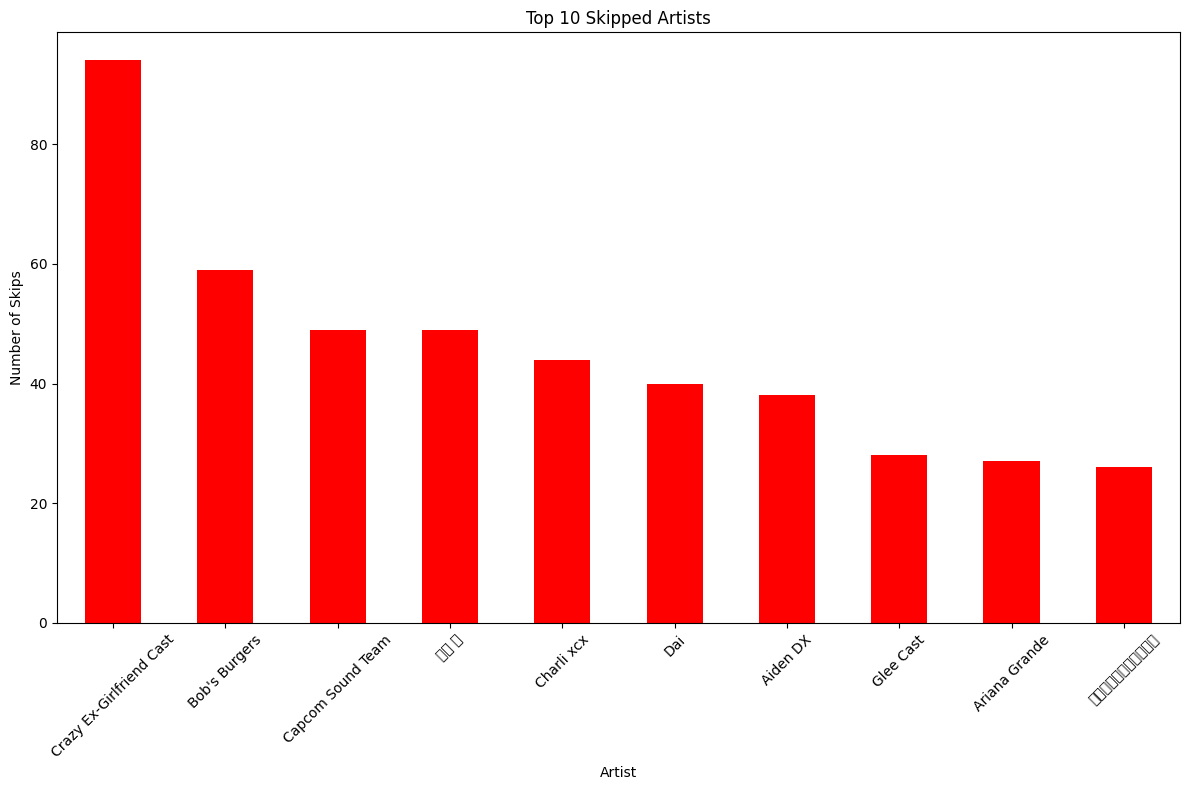

In [31]:
# Identify the skipped tracks by artist
skipped_by_artist = spotify_data[spotify_data['skipped'] == 1].groupby('album_artist_name')['skipped'].count().sort_values(ascending=False)

# Plot skipped tracks by artist
plt.figure(figsize=(12, 8))
skipped_by_artist.head(10).plot(kind='bar', color='red')
plt.title('Top 10 Skipped Artists')
plt.xlabel('Artist')
plt.ylabel('Number of Skips')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_path_artist = '/content/spotify-listening-data/output/top_skipped_artists.png'
plt.savefig(output_path_artist)
plt.show()

# You can do something similar with genres if you have a column for genres, for example:
# skipped_by_genre = spotify_data[spotify_data['skipped'] == 1].groupby('genre')['skipped'].count().sort_values(ascending=False)


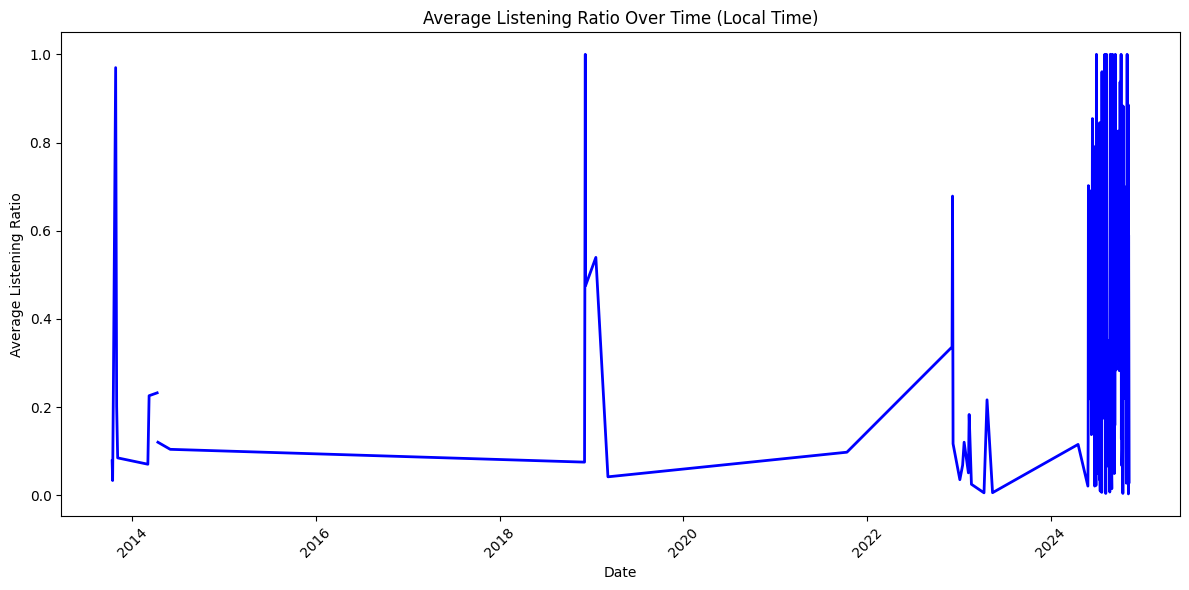

Chart saved to /content/spotify-listening-data/output/avg_listening_ratio_over_time_local.png


In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'end_time_UTC' is in datetime format
spotify_data['end_time_UTC'] = pd.to_datetime(spotify_data['end_time_UTC'])

# Manually adjust UTC to local time by adding the offset (we assume the 'utc_offset' is in hours)
spotify_data['end_time_local'] = spotify_data['end_time_UTC'] + pd.to_timedelta(spotify_data['utc_offset'], unit='h')

# Calculate the listening ratio (ms_played / song_duration_ms)
spotify_data['listening_ratio'] = spotify_data['ms_played'] / spotify_data['song_duration_ms']

# Group by the date of the local time for daily trends (you can also group by month or hour)
spotify_data['date_local'] = spotify_data['end_time_local'].dt.date
daily_avg_ratio_local = spotify_data.groupby('date_local')['listening_ratio'].mean()

# Plot the daily average listening ratio over time
plt.figure(figsize=(12, 6))
daily_avg_ratio_local.plot(kind='line', color='blue', lw=2)
plt.title('Average Listening Ratio Over Time (Local Time)')
plt.xlabel('Date')
plt.ylabel('Average Listening Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_path_ratio_local_time = '/content/spotify-listening-data/output/avg_listening_ratio_over_time_local.png'
plt.savefig(output_path_ratio_local_time)
plt.show()

print(f"Chart saved to {output_path_ratio_local_time}")

<ipython-input-38-7d94f8415d42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_data_2024_onwards['listening_ratio'] = spotify_data_2024_onwards['ms_played'] / spotify_data_2024_onwards['song_duration_ms']
<ipython-input-38-7d94f8415d42>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_data_2024_onwards['date_local'] = spotify_data_2024_onwards['end_time_local'].dt.date


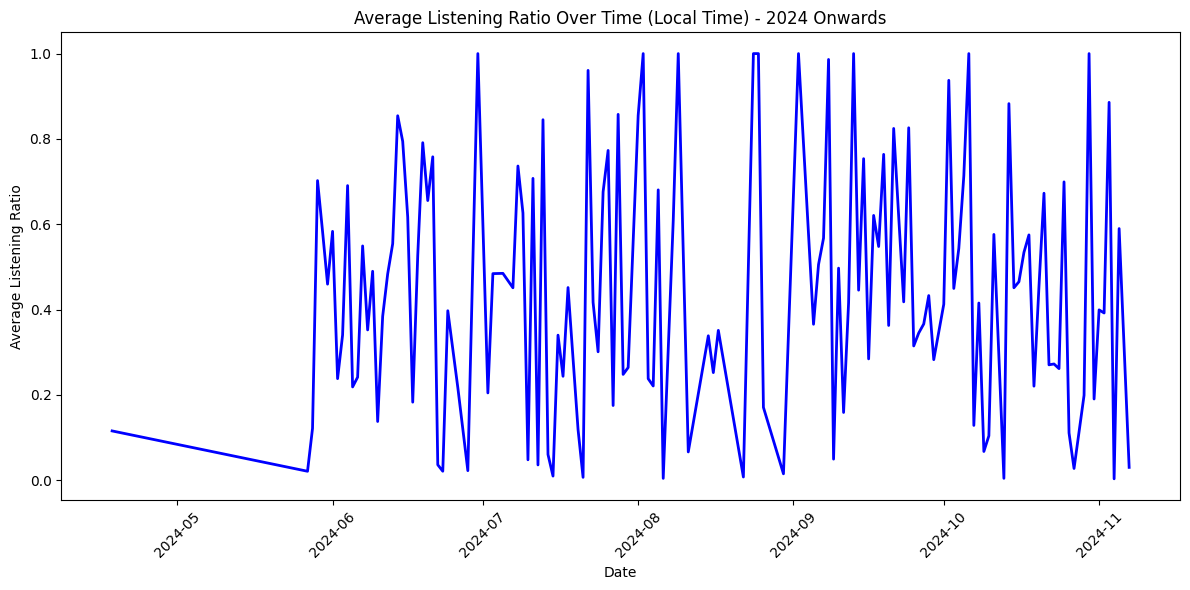

Chart for 2024 onwards saved to /content/spotify-listening-data/output/avg_listening_ratio_over_time_local_2024_onwards.png


In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'end_time_UTC' is in datetime format
spotify_data['end_time_UTC'] = pd.to_datetime(spotify_data['end_time_UTC'])

# Manually adjust UTC to local time by adding the offset (we assume the 'utc_offset' is in hours)
spotify_data['end_time_local'] = spotify_data['end_time_UTC'] + pd.to_timedelta(spotify_data['utc_offset'], unit='h')

# Filter for 2024 onwards
spotify_data_2024_onwards = spotify_data[spotify_data['end_time_local'].dt.year >= 2024]

# Calculate the listening ratio (ms_played / song_duration_ms)
spotify_data_2024_onwards['listening_ratio'] = spotify_data_2024_onwards['ms_played'] / spotify_data_2024_onwards['song_duration_ms']

# Group by the date of the local time for daily trends (you can also group by month or hour)
spotify_data_2024_onwards['date_local'] = spotify_data_2024_onwards['end_time_local'].dt.date
daily_avg_ratio_local_2024_onwards = spotify_data_2024_onwards.groupby('date_local')['listening_ratio'].mean()

# Plot the daily average listening ratio over time for 2024 onwards
plt.figure(figsize=(12, 6))
daily_avg_ratio_local_2024_onwards.plot(kind='line', color='blue', lw=2)
plt.title('Average Listening Ratio Over Time (Local Time) - 2024 Onwards')
plt.xlabel('Date')
plt.ylabel('Average Listening Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
output_path_ratio_local_2024_onwards = '/content/spotify-listening-data/output/avg_listening_ratio_over_time_local_2024_onwards.png'
plt.savefig(output_path_ratio_local_2024_onwards)
plt.show()

print(f"Chart for 2024 onwards saved to {output_path_ratio_local_2024_onwards}")
